In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
from music21 import *

import os
import glob
import numpy as np

import matplotlib.pyplot as plt

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

from keras.models import load_model
import keras.utils.np_utils as np_utils

Using TensorFlow backend.


In [3]:
DATASET_PATH = "/home/mmatsi/Dataset_Piano"
blacklist = [
]

In [4]:
notes = []

for file in glob.glob(f"{DATASET_PATH}/*.mid"):
    if file in blacklist:
        print("Skipped", file)
        continue
        
    print(file)
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    print(parts)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

/home/mmatsi/Dataset_Piano/Finalfantasy5gilgameshp.mid
<music21.stream.Score 0x7fc7e52360b8>
/home/mmatsi/Dataset_Piano/FF4.mid
<music21.stream.Score 0x7fc7e4d44eb8>
/home/mmatsi/Dataset_Piano/gerudo.mid
<music21.stream.Score 0x7fc7e4eee0f0>
/home/mmatsi/Dataset_Piano/Finalfantasy6fanfarecomplete.mid
<music21.stream.Score 0x7fc7e469deb8>
/home/mmatsi/Dataset_Piano/ViviinAlexandria.mid
<music21.stream.Score 0x7fc7e422a1d0>
/home/mmatsi/Dataset_Piano/Suteki_Da_Ne_(Piano_Version).mid
<music21.stream.Score 0x7fc7e5034550>
/home/mmatsi/Dataset_Piano/FFIII_Edgar_And_Sabin_Piano.mid
<music21.stream.Score 0x7fc7e470d400>
/home/mmatsi/Dataset_Piano/FF3_Third_Phase_Final_(Piano).mid
<music21.stream.Score 0x7fc7e475f0f0>
/home/mmatsi/Dataset_Piano/FFIXQuMarshP.mid
<music21.stream.Score 0x7fc7e4eed438>
/home/mmatsi/Dataset_Piano/sobf.mid
<music21.stream.Score 0x7fc7e4eed5f8>
/home/mmatsi/Dataset_Piano/In_Zanarkand.mid
<music21.stream.Score 0x7fc7e46d35c0>
/home/mmatsi/Dataset_Piano/ff4-airship.mid

In [5]:
sequence_length = 100
# get all pitch names
pitchnames = sorted(set(item for item in notes))
n_vocab = len(pitchnames)
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# norma
network_input = network_input / float(n_vocab)
network_output = np_utils.to_categorical(network_output)

In [6]:
K.clear_session()
model = Sequential()
    
#embedding layer
# model.add(Input(shape=(100,))) 

model.add(Conv1D(64,3, padding='causal',activation='relu', input_shape=(network_input.shape[1], network_input.shape[2])))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(n_vocab, activation='softmax'))
    
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 64)           256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 128)           0         
______________________________________

In [9]:
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
history = model.fit(network_input, network_output, epochs=500, batch_size=128, callbacks=callbacks_list)

Epoch 1/500
57077/57077 [==============================] - 9s 157us/step - loss: 4.7709
Epoch 2/500
57077/57077 [==============================] - 10s 176us/step - loss: 4.7856
Epoch 3/500
57077/57077 [==============================] - 15s 255us/step - loss: 4.7696
Epoch 4/500
57077/57077 [==============================] - 12s 210us/step - loss: 4.7801
Epoch 5/500
57077/57077 [==============================] - 13s 224us/step - loss: 4.7795
Epoch 6/500
57077/57077 [==============================] - 12s 215us/step - loss: 4.7915
Epoch 7/500
57077/57077 [==============================] - 11s 186us/step - loss: 4.7873
Epoch 8/500
57077/57077 [==============================] - 11s 185us/step - loss: 4.7854
Epoch 9/500
57077/57077 [==============================] - 11s 187us/step - loss: 4.7865
Epoch 10/500
57077/57077 [==============================] - 11s 187us/step - loss: 4.7809
Epoch 11/500
57077/57077 [==============================] - 11s 194us/step - loss: 4.7870
Epoch 12/500
57077/5

57077/57077 [==============================] - 9s 161us/step - loss: 4.7569
Epoch 183/500
57077/57077 [==============================] - 9s 162us/step - loss: 4.7568
Epoch 184/500
57077/57077 [==============================] - 9s 161us/step - loss: 4.7567
Epoch 185/500
57077/57077 [==============================] - 9s 161us/step - loss: 4.7566
Epoch 186/500
57077/57077 [==============================] - 9s 161us/step - loss: 4.7564
Epoch 187/500
57077/57077 [==============================] - 9s 162us/step - loss: 4.7563
Epoch 188/500
57077/57077 [==============================] - 9s 161us/step - loss: 4.7563
Epoch 189/500
57077/57077 [==============================] - 9s 161us/step - loss: 4.7562
Epoch 190/500
57077/57077 [==============================] - 9s 161us/step - loss: 4.7561
Epoch 191/500
57077/57077 [==============================] - 9s 161us/step - loss: 4.7560
Epoch 192/500
57077/57077 [==============================] - 9s 161us/step - loss: 4.7559
Epoch 193/500
57077/5707

57077/57077 [==============================] - 3s 45us/step - loss: 4.7456
Epoch 366/500
57077/57077 [==============================] - 3s 45us/step - loss: 4.7456
Epoch 367/500
57077/57077 [==============================] - 3s 47us/step - loss: 4.7455
Epoch 368/500
57077/57077 [==============================] - 3s 47us/step - loss: 4.7455
Epoch 369/500
57077/57077 [==============================] - 2s 43us/step - loss: 4.7456
Epoch 370/500
57077/57077 [==============================] - 3s 44us/step - loss: 4.7455
Epoch 371/500
57077/57077 [==============================] - 3s 46us/step - loss: 4.7454
Epoch 372/500
57077/57077 [==============================] - 3s 44us/step - loss: 4.7454
Epoch 373/500
57077/57077 [==============================] - 3s 45us/step - loss: 4.7454
Epoch 374/500
57077/57077 [==============================] - 3s 45us/step - loss: 4.7453
Epoch 375/500
57077/57077 [==============================] - 3s 46us/step - loss: 4.7453
Epoch 376/500
57077/57077 [========

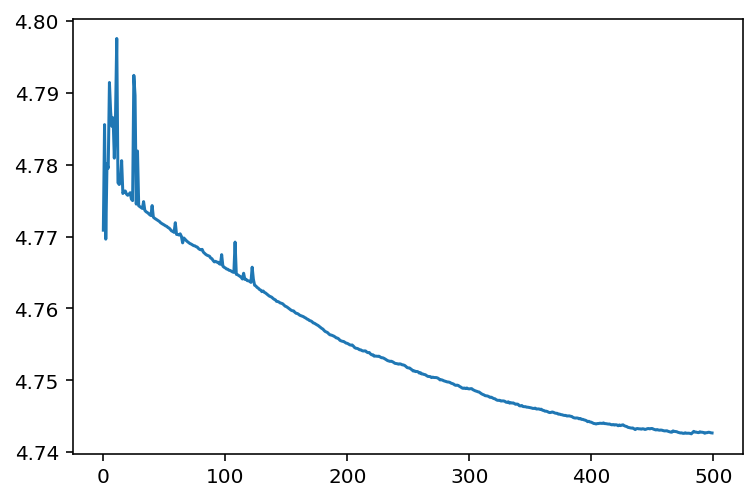

In [10]:
plt.plot(history.history['loss'])

In [76]:
# model = load_model("weights-improvement-74-3.3395-bigger.hdf5")
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = []
# generate 500 notes
for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output+=(result)
    pattern = np.append(pattern, index)
    pattern = pattern[1:len(pattern)]

In [10]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output.mid')

'test_output.mid'